In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load test set tags

In [2]:
tag = pd.read_csv('../data-processed/full-data/pid-track-ratings-train-test-tags.csv')

In [3]:
tag.head()

,pid,pos,track_uri,artist_uri,binary_rating,pos_rating,train_test,test_first_random,seed_tracks_num,num_tracks,hold_out
0,491000,0,spotify:track:3giQ7393501IRNrd8iHugf,spotify:artist:2ptmyXoL7poH6Zq62h1QT9,1,10.000000,train,1,36.0,177,0
1,491000,1,spotify:track:3jpcVaeyNjWgjqIxAiWasz,spotify:artist:2ptmyXoL7poH6Zq62h1QT9,1,9.949153,train,1,36.0,177,0
2,491000,2,spotify:track:1uuqRaSJAiQ6VB8BWblXWJ,spotify:artist:2ptmyXoL7poH6Zq62h1QT9,1,9.898305,train,1,36.0,177,0
3,491000,3,spotify:track:7gXpcXwtmEiQzskYJmtGgk,spotify:artist:2ptmyXoL7poH6Zq62h1QT9,1,9.847458,train,1,36.0,177,0
4,491000,4,spotify:track:5wtIWwOtowY2howCZ7Veq2,spotify:artist:2ptmyXoL7poH6Zq62h1QT9,1,9.796610,train,1,36.0,177,0


In [4]:
tag =  tag[tag.train_test=='test']

In [5]:
tag = tag[['pid','test_first_random']].drop_duplicates()

In [6]:
tag = tag.rename(columns = {'test_first_random':'seed_track_order'})

In [7]:
tag['seed_track_order'] = tag['seed_track_order'].map({1:'first n', 0:'random n'})

In [8]:
tag.head()

,pid,seed_track_order
46431809,491004,first n
46431934,491007,first n
46431964,491021,first n
46432019,491029,first n
46432059,491031,first n


# Load evaluation results

In [9]:
evaluation_res = pd.DataFrame()
path_to_jsonfiles = '../evaluation/'
for file in os.listdir(path_to_jsonfiles):
    df0=pd.read_csv(f'{path_to_jsonfiles}{file}')
    evaluation_res = evaluation_res.append(df0)

In [10]:
evaluation_res.head()

,pid,R-Precision,nDCG,rating,model
0,28008,0.260870,0.533907,binary,ALS
1,852629,0.223077,0.754124,binary,ALS
2,813022,0.000000,0.267618,binary,ALS
3,740530,0.000000,0.195070,binary,ALS
4,930048,0.159664,0.710340,binary,ALS


In [11]:
evaluation_res.shape

(61000, 5)

# Group

In [12]:
evaluation_res.model.unique()

array(['ALS', 'CB_audio_features', 'SVD_100', 'SVD_50'], dtype=object)

In [13]:
evaluation_res['parent_model'] = evaluation_res['model'].map({
    'ALS':'ALS', 
    'CB_audio_features':'CB', 
    'SVD_100':'SVD', 
    'SVD_50':'SVD'})

In [14]:
evaluation_res.head()

,pid,R-Precision,nDCG,rating,model,parent_model
0,28008,0.260870,0.533907,binary,ALS,ALS
1,852629,0.223077,0.754124,binary,ALS,ALS
2,813022,0.000000,0.267618,binary,ALS,ALS
3,740530,0.000000,0.195070,binary,ALS,ALS
4,930048,0.159664,0.710340,binary,ALS,ALS


In [15]:
evaluation_res = evaluation_res.merge(tag, how = 'left', left_on = 'pid', right_on = 'pid')

In [16]:
evaluation_res.head()

,pid,R-Precision,nDCG,rating,model,parent_model,seed_track_order
0,28008,0.260870,0.533907,binary,ALS,ALS,first n
1,852629,0.223077,0.754124,binary,ALS,ALS,random n
2,813022,0.000000,0.267618,binary,ALS,ALS,first n
3,740530,0.000000,0.195070,binary,ALS,ALS,random n
4,930048,0.159664,0.710340,binary,ALS,ALS,first n


In [17]:
summary = evaluation_res.groupby(['parent_model','rating','seed_track_order'])[['R-Precision','nDCG']].mean().reset_index()

In [18]:
summary

,parent_model,rating,seed_track_order,R-Precision,nDCG
0,ALS,binary,first n,0.091315,0.395576
1,ALS,binary,random n,0.117198,0.438992
2,ALS,pos,first n,0.099298,0.419267
3,ALS,pos,random n,0.124589,0.463402
4,CB,na,first n,0.000000,0.001483
5,CB,na,random n,0.000000,0.001385
6,SVD,binary,first n,0.094110,0.392728
7,SVD,binary,random n,0.121763,0.440598
8,SVD,pos,first n,0.091168,0.388928
9,SVD,pos,random n,0.113560,0.428842


In [31]:
summary.to_csv('../evaluation/summary.csv', index = None)

# Visualise

In [32]:
summary = pd.read_csv('../evaluation/summary.csv')

[Text(0.5, 0, ''), Text(0, 0.5, 'model')]

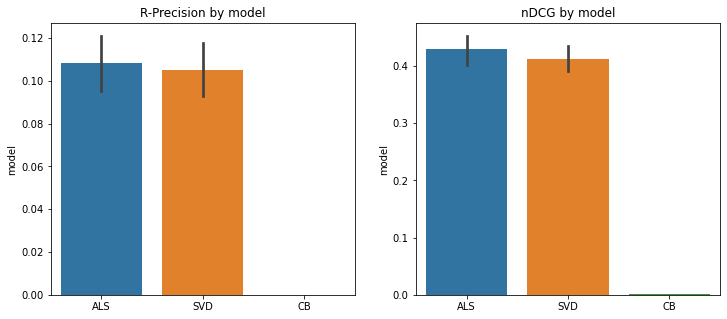

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
data = summary
sns.barplot(data=data, x ='parent_model', y = 'R-Precision', order = ['ALS','SVD','CB'], ax = ax[0]).set_title('R-Precision by model')
sns.barplot(data=data, x ='parent_model', y = 'nDCG',  order = ['ALS','SVD','CB'], ax = ax[1]).set_title('nDCG by model')
ax[0].set(xlabel='', ylabel='model')
ax[1].set(xlabel='', ylabel='model')

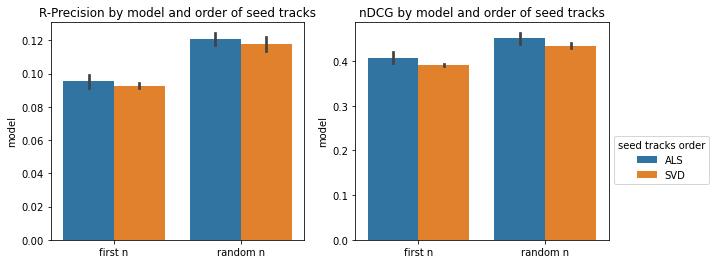

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

data = summary[summary['parent_model']!='CB']
hue = 'parent_model'

sns.barplot(data=data, x ='seed_track_order', y = 'R-Precision', hue = hue, ax = ax[0]).set_title('R-Precision by model and order of seed tracks')
sns.barplot(data=data, x ='seed_track_order', y = 'nDCG', hue = hue, ax = ax[1]).set_title('nDCG by model and order of seed tracks')
ax[0].set(xlabel='', ylabel='model')
ax[0].set(xlabel='', ylabel='model')
ax[1].set(xlabel='', ylabel='model')
ax[0].get_legend().remove()
ax[1].legend(loc= 'upper left', title = 'seed tracks order', bbox_to_anchor=(1,0.5))

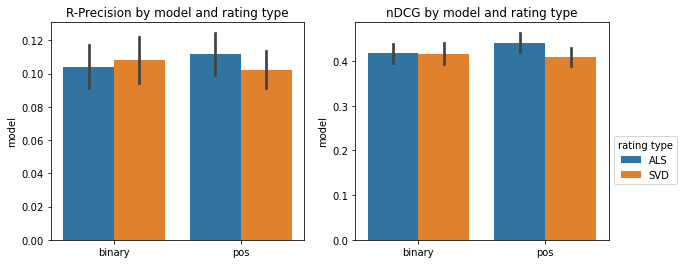

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
data = summary[summary['parent_model']!='CB']
hue = 'parent_model'

sns.barplot(data=data, x ='rating', y = 'R-Precision', hue = hue, ax = ax[0]).set_title('R-Precision by model and rating type')
sns.barplot(data=data, x ='rating', y = 'nDCG', hue = hue, ax = ax[1]).set_title('nDCG by model and rating type')
ax[0].set(xlabel='', ylabel='model')
ax[0].set(xlabel='', ylabel='model')
ax[1].set(xlabel='', ylabel='model')
ax[0].get_legend().remove()
ax[1].legend(loc= 'upper left', title = 'rating type', bbox_to_anchor=(1,0.5))